## Setting up dependencies

In [1]:
!pip install timm flash_attn einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 57.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cuspa

In [2]:
import os
import glob
import PIL
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import AutoProcessor, AutoModelForCausalLM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Datasets/Florence2_Data"

In [ ]:
png_files = glob.glob(os.path.join(DATA_PATH, "*.png"))
images = [PIL.Image.open(file) for file in png_files][:15]

## Setting up the model
#### Uncomment the lines inferring ```cuda()``` to change the runtime to GPU, and comment the line without ```cuda()```.

In [3]:
model_id = 'microsoft/Florence-2-base'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
# model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
def annotate_image(image, prompt):
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      # input_ids=inputs["input_ids"].cuda(),
      input_ids=inputs["input_ids"],
      # pixel_values=inputs["pixel_values"].cuda(),
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [ ]:
prompt = "<OD>"
results = annotate_image(images[0], prompt)
print(results)

{'<OD>': {'bboxes': [[583.3599853515625, 275.7599792480469, 601.2799682617188, 316.0799865722656], [173.1199951171875, 332.3999938964844, 325.44000244140625, 474.47998046875], [5.440000057220459, 401.03997802734375, 109.75999450683594, 474.9599914550781], [182.0800018310547, 394.79998779296875, 316.47998046875, 454.3199768066406], [58.55999755859375, 251.27999877929688, 88.0, 329.5199890136719], [427.1999816894531, 321.8399963378906, 440.6399841308594, 330.9599914550781], [457.91998291015625, 167.27999877929688, 580.7999877929688, 247.9199981689453], [415.67999267578125, 289.1999816894531, 500.1600036621094, 474.0], [494.3999938964844, 331.44000244140625, 587.2000122070312, 474.47998046875], [587.2000122070312, 166.8000030517578, 633.9199829101562, 474.9599914550781], [460.47998046875, 305.03997802734375, 584.6400146484375, 340.55999755859375], [475.1999816894531, 312.7200012207031, 584.0, 340.0799865722656], [311.3599853515625, 327.6000061035156, 399.67999267578125, 456.239990234375]]

### ```plot_bbox()``` will plot the bounding box on top of image along with ```actual_label``` if provided

In [5]:
def plot_bbox(image, data, actual_label=None):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    if actual_label is not None:
      for bbox, label in zip(actual_label['bboxes'], actual_label['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='green', alpha=0.5))
    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

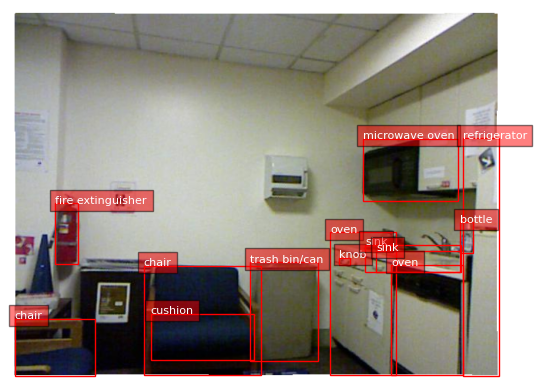

In [ ]:
plot_bbox(images[0], results['<OD>'])

### Dense region caption -- Added this to get a denser annotation, it detects more objects and also objects with greater detail, e.g. chair -> wooden armchair

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [ ]:
prompt = '<DENSE_REGION_CAPTION>'
results = annotate_image(images[0], prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[173.1199951171875, 332.3999938964844, 325.44000244140625, 474.47998046875], [587.8399658203125, 166.3199920654297, 633.9199829101562, 474.9599914550781], [494.3999938964844, 331.44000244140625, 587.2000122070312, 474.47998046875], [415.67999267578125, 311.7599792480469, 498.8799743652344, 474.0], [311.3599853515625, 327.6000061035156, 399.67999267578125, 456.239990234375], [457.91998291015625, 167.27999877929688, 580.7999877929688, 247.9199981689453], [5.440000057220459, 401.03997802734375, 109.75999450683594, 474.9599914550781], [460.47998046875, 305.03997802734375, 584.6400146484375, 340.55999755859375], [6.079999923706055, 130.3199920654297, 50.87999725341797, 212.39999389648438], [475.1999816894531, 312.7200012207031, 584.0, 340.0799865722656], [58.55999755859375, 251.27999877929688, 88.0, 329.5199890136719], [533.4400024414062, 288.7200012207031, 583.3599853515625, 322.32000732421875], [130.239990234375, 223.44000244140625, 163.5199890136718

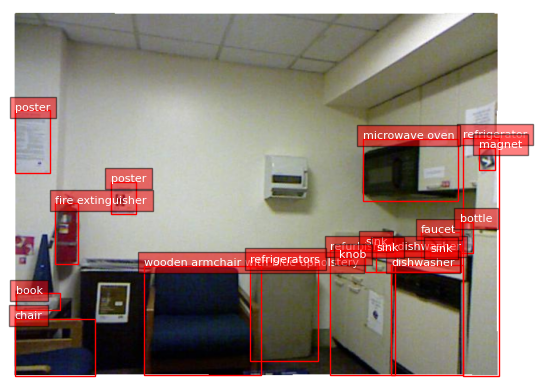

In [ ]:
plot_bbox(images[0], results['<DENSE_REGION_CAPTION>'])

## Running the code for all the images, use the following prompt to get dense annotation labels:
#### ```prompt = '<DENSE_REGION_CAPTION>'```

In [ ]:
results = []
for image in images:
    prompt = "<OD>"
    result = annotate_image(image, prompt)
    results.append(result)

In [ ]:
# Create an empty dictionary to store the results to be dumped into a JSON
results_dict = {}

# Loop through the results and images
for result, image in zip(results, images):
  filename = image.filename
  key = filename.split('/')[-1]
  results_dict[key] = result

json_results = json.dumps(results_dict, indent=4)
with open('/content/drive/MyDrive/Datasets/results.json', 'w') as f:
  f.write(json_results)

# Testing

In [ ]:
TEST_PATH = "/content/drive/MyDrive/Datasets/test"

In [ ]:
test_files = glob.glob(os.path.join(TEST_PATH, "*.jpg"))
test_images = [PIL.Image.open(file) for file in test_files]

In [ ]:
len(test_images)

6

In [ ]:
test_results = []
for image in test_images:
    prompt = "<OD>"
    result = annotate_image(image, prompt)
    test_results.append(result)

In [ ]:
# Create an empty dictionary to store the results to be dumped into a JSON
results_dict = {}

# Loop through the results and images
for result, image in zip(test_results, test_images):
  filename = image.filename
  key = filename.split('/')[-1]
  results_dict[key] = result

json_results = json.dumps(results_dict, indent=4)
with open('/content/drive/MyDrive/Datasets/results_test.json', 'w') as f:
  f.write(json_results)

In [ ]:
test_images[3].filename

'/content/drive/MyDrive/Datasets/test/000000267903_jpg.rf.0087200637b2d5317428aabe8e7a0162.jpg'

## Sample Test 1

In [ ]:
prompt = "<OD>"
results = annotate_image(test_images[3], prompt)
print(results)

{'<OD>': {'bboxes': [[73.27999877929688, 15.123000144958496, 337.6000061035156, 292.02301025390625], [352.9599914550781, 245.58900451660156, 523.2000122070312, 425.3609924316406]], 'labels': ['sink', 'toilet']}}


In [ ]:
test_labels = {}
with open('/content/drive/MyDrive/Datasets/test/test.json', 'r') as f:
  test_labels = json.load(f)

In [ ]:
test_labels["000000267903_jpg.rf.0087200637b2d5317428aabe8e7a0162.jpg"]["<OD>"]

{'bboxes': [[1, 1, 1, 2], [120, 33, 523, 432]], 'labels': ['toilet', 'sink']}

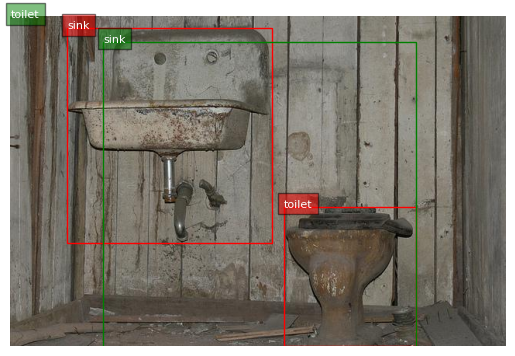

In [ ]:
plot_bbox(test_images[3], results['<OD>'], test_labels["000000267903_jpg.rf.0087200637b2d5317428aabe8e7a0162.jpg"]["<OD>"])

## Sample Test 2

In [9]:
x = {'<OD>': {'bboxes': [[79,133,464,138]], 'labels': ['airplane']}}

In [6]:
img = PIL.Image.open('/content/000000452122_jpg.rf.6f05c6bae3e074cb9ed08311a9cbc8bd.jpg')

In [7]:
prompt = "<OD>"
results = annotate_image(img, prompt)
print(results)

{'<OD>': {'bboxes': [[73.91999816894531, 130.44850158691406, 552.0, 273.9205017089844]], 'labels': ['airplane']}}


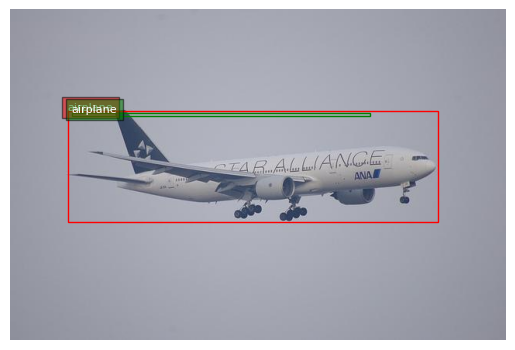

In [12]:
plot_bbox(img, results['<OD>'], x['<OD>'])

## Sample Test 3

In [15]:
x = {'<OD>': {'bboxes': [[58,94,373,329],[421,44,131,175]], 'labels': ['zebra', 'zebra']}}
img = PIL.Image.open('/content/000000093965_jpg.rf.82d3c2473bd812d35daa9ffd51035ad3.jpg')
prompt = "<OD>"
results = annotate_image(img, prompt)
print(results)

{'<OD>': {'bboxes': [[56.63999938964844, 97.11249542236328, 431.67999267578125, 422.9534912109375], [419.5199890136719, 45.01449966430664, 553.9199829101562, 220.0454864501953]], 'labels': ['zebra', 'zebra']}}


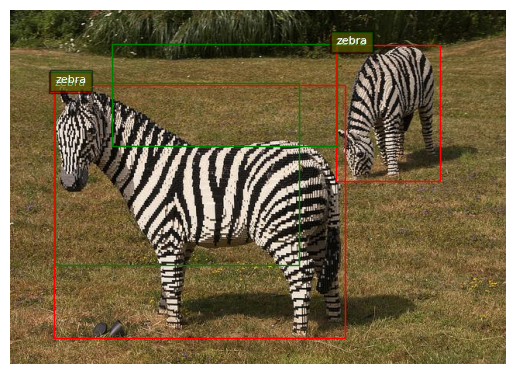

In [16]:
plot_bbox(img, results['<OD>'], x['<OD>'])

## Sample Test 4

In [17]:
x = {'<OD>': {'bboxes': [[155,88,188,190]], 'labels': ['tvmonitor']}}
img = PIL.Image.open('/content/2007_000039_jpg.rf.eb878cf899cc46bcc3a2d91c6dfede0d.jpg')
prompt = "<OD>"
results = annotate_image(img, prompt)
print(results)

{'<OD>': {'bboxes': [[468.25, 270.5625, 499.25, 374.4375], [204.75, 0.1875, 398.75, 43.3125], [107.25, 255.9375, 344.75, 374.4375], [376.25, 345.5625, 418.25, 374.4375], [340.25, 89.8125, 373.75, 133.3125], [0.25, 0.1875, 273.25, 374.4375], [0.25, 0.1875, 160.75, 374.4375], [329.75, 219.5625, 499.25, 374.4375], [159.25, 90.1875, 364.25, 274.6875]], 'labels': ['bowl', 'cabinetry', 'computer keyboard', 'computer mouse', 'power plugs and sockets', 'refrigerator', 'refrigerator', 'sink', 'television']}}


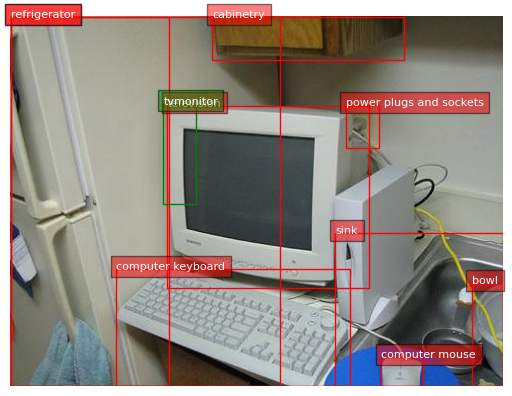

In [18]:
plot_bbox(img, results['<OD>'], x['<OD>'])


## Sample Test 5

In [19]:
x = {'<OD>': {'bboxes': [[
                33,
                14,
                454,
                180
            ]], 'labels': ['airplane']}}
img = PIL.Image.open('/content/2011_002930_jpg.rf.7084f364b712a0bbdcf3ae24edd70f53.jpg')
prompt = "<OD>"
results = annotate_image(img, prompt)
print(results)

{'<OD>': {'bboxes': [[15.75, 15.769999504089355, 489.25, 193.38999938964844], [153.25, 146.9099884033203, 254.75, 184.42599487304688]], 'labels': ['airplane', 'airplane']}}


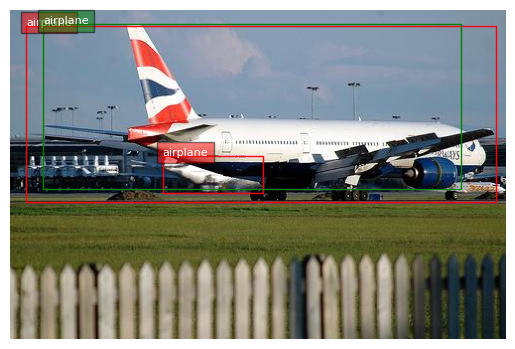

In [20]:
plot_bbox(img, results['<OD>'], x['<OD>'])

In [22]:
# Finding IOU (Intersection Over Union) for the bigger primary Airplane, as it is the only common object between labels and predictions
def compute_iou(box1, box2):
    """
    Computes the Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (list): The first bounding box, in the format [x1, y1, x2, y2].
        box2 (list): The second bounding box, in the format [x1, y1, x2, y2].

    Returns:
        float: The IoU between the two bounding boxes.
    """

    # Calculate the intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area

    # Return the IoU
    return intersection_area / union_area


In [23]:
compute_iou([33,14,454,180], [15.75, 15.769999504089355, 489.25, 193.38999938964844])

0.8155008585659932

## Sample Test 6

In [26]:
x = {'<OD>': {'bboxes': [[33,14,454,180]], 'labels': ['cat']}}
img = PIL.Image.open('/content/2011_002211_jpg.rf.d5383ad32cd0ff1a67b7e780045b2d95.jpg')
prompt = "<OD>"
results = annotate_image(img, prompt)
print(results)

{'<OD>': {'bboxes': [[6.75, 59.4375, 467.75, 329.8125]], 'labels': ['cat']}}


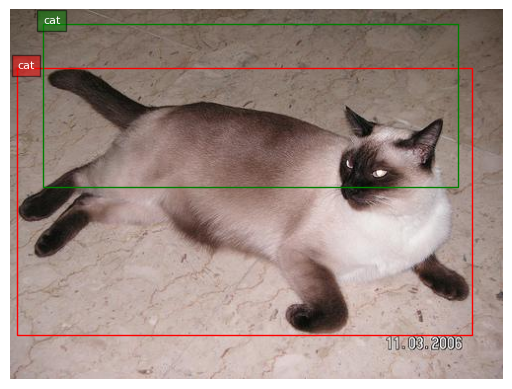

In [27]:
plot_bbox(img, results['<OD>'], x['<OD>'])

In [28]:
compute_iou([33,14,454,180], [6.75, 59.4375, 467.75, 329.8125])

0.35489048330204365

## Sample Test 6

In [31]:
x = {'<OD>': {'bboxes': [[366,264,55,110],[336,209,37,140],[238,192,21,68],[31,0,176,93],[0,89,175,285],[66,100,166,274],[158,97,67,117],[170,82,124,174],[233,114,172,174],[352,120,67,91],[396,131,103,204], [176,245,323,129]],'labels': ['bottle', 'bottle', 'bottle', 'tvmonitor', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'diningtable']}}
img = PIL.Image.open('/content/2011_002966_jpg.rf.23a3a49b69dfa0f7498f3f1622f05b18.jpg')
prompt = "<OD>"
results = annotate_image(img, prompt)
print(results)

{'<OD>': {'bboxes': [[363.25, 264.5625, 421.75, 374.4375], [334.75, 211.6875, 374.25, 346.3125], [236.25, 192.1875, 259.75, 260.4375], [453.75, 293.4375, 499.25, 374.4375], [364.25, 348.1875, 420.75, 374.4375], [335.25, 320.0625, 358.75, 345.1875], [277.25, 237.9375, 304.75, 258.5625], [31.75, 106.3125, 105.75, 203.8125], [417.25, 140.0625, 474.75, 215.8125], [357.25, 135.5625, 408.75, 209.8125], [102.25, 114.9375, 147.25, 182.8125], [231.75, 87.9375, 278.75, 146.0625], [273.75, 120.1875, 319.75, 176.0625], [0.25, 88.6875, 176.75, 374.4375], [267.75, 112.3125, 409.25, 293.4375], [169.75, 242.4375, 499.25, 374.4375], [62.25, 100.3125, 229.75, 374.4375], [391.75, 127.6875, 499.25, 374.4375], [166.25, 81.9375, 294.25, 260.0625], [349.75, 120.5625, 421.25, 293.4375]], 'labels': ['bottle', 'bottle', 'bottle', 'drinking straw', 'drinking straw', 'drinking straw', 'drinking straw', 'human face', 'human face', 'human face', 'human face', 'human face', 'human face', 'man', 'man', 'table', 'woma

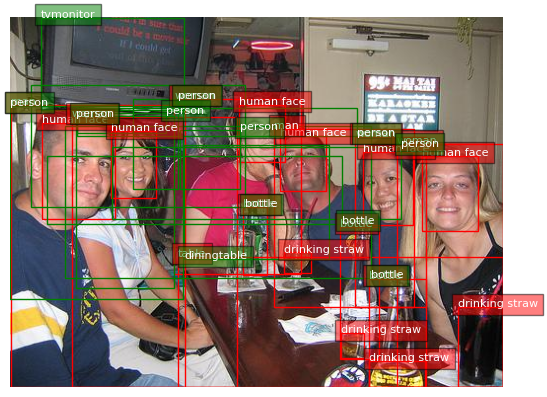

In [32]:
plot_bbox(img, results['<OD>'], x['<OD>'])